In [1]:
import torch
import matplotlib.pyplot as plt
from utils.util import *
from utils.custom_dataset import *
torch.backends.cudnn.enabled = False

### 0. 데이터확인

In [2]:
PreprocessObj = PreprocessData()
PreprocessObj.get_solve_array()
PreprocessObj.scaling_and_resize()

100%|██████████| 550/550 [00:03<00:00, 155.45it/s]


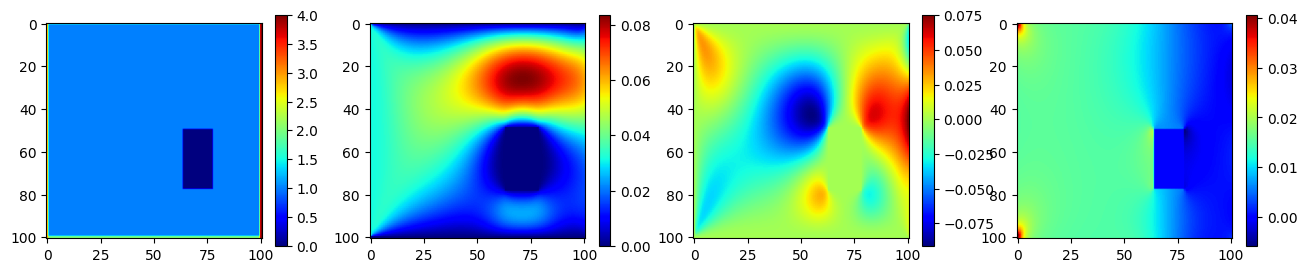

In [3]:
plot_idx = 0 
plt.figure(figsize=[16,3])
plt.subplot(1,4,1)
plt.imshow(PreprocessObj.boundary_data[plot_idx],cmap='jet')
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(PreprocessObj.ux_data[plot_idx],cmap='jet')
plt.colorbar()
plt.subplot(1,4,3)
plt.imshow(PreprocessObj.uy_data[plot_idx],cmap='jet')
plt.colorbar()
plt.subplot(1,4,4)
plt.imshow(PreprocessObj.p_data[plot_idx],cmap='jet')
plt.colorbar()

### 1. 데이터세트 로드

In [4]:
import torchvision.transforms as transforms

dataset = CustomDatasetUNet(transform=transforms.Compose([transforms.ToTensor()]),
                            target_transform=transforms.Compose([transforms.ToTensor()]))

100%|██████████| 550/550 [00:03<00:00, 154.29it/s]


In [5]:
from torch.utils.data import random_split

dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset,[train_size,validation_size,test_size],
                                                               generator=torch.Generator().manual_seed(42))
print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 440
Validation Data Size : 55
Testing Data Size : 55


In [12]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [7]:
for a,b,d,e,f in train_dataloader:
    print(a.shape)
    print(b.shape)
    print(d.shape)
    print(e.shape)
    print(f.shape)
    break

torch.Size([4, 1, 101, 101])
torch.Size([4, 8])
torch.Size([4, 1, 101, 101])
torch.Size([4, 1, 101, 101])
torch.Size([4, 1, 101, 101])


### 2. 모델 로드

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from model.unet_model import *
model = UNet().to(device)

### 3. 학습/검증 수행

In [8]:
def train_loop(dataloader,model,loss_fn,optimizer):
    
    # 입력 데이터세트의 총 길이 
    size = len(dataloader.dataset) # 320

    # 배치 총 개수 (320/4 = 80) 
    num_batches = len(dataloader)
    
    # loss 초기화
    train_loss = 0

    # train_loop 
    for batch, (bdr,opr,ux,uy,p) in enumerate(dataloader): 
        
        # 타입 & device 변환
        bdr = bdr.type(torch.float32).to(device)
        opr = opr.type(torch.int32).to(device)
        ux = ux.type(torch.float32).to(device)
        uy = uy.type(torch.float32).to(device)
        p = p.type(torch.float32).to(device)

        X = [bdr,opr]
        y = torch.concat([ux,uy,p],axis=1)
        
        # 모델 예측
        pred = model(X)

        # Loss 계산
        loss = loss_fn(pred,y)
    
        # Backpropagation
        optimizer.zero_grad() # 이전 루프에서 각 파라미터들에 저장된 .grad를 초기화
        loss.backward() # 각 파라미터들의 .grad값에 변화정도가 저장이 됨.
        optimizer.step() # 최적화함수에 맞게, 각 파라미터 업데이트

        # LOSS 
        train_loss += loss.item() # item()을 통해, 변수에서 값만 가져옴

    train_loss /= num_batches
    print(f"Train loss: {train_loss:>8f}")
    
    return train_loss

def validation_loop(dataloader,model,loss_fn):

    # 입력 데이터세트의 총 길이
    size = len(dataloader.dataset) # 40
    
    # 배치 총 개수 (40/4 = 10)
    num_batches = len(dataloader)

    # loss 초기화
    validation_loss = 0

    # 테스트 단계이므로 gradient 옵션 해제
    with torch.no_grad():
        for bdr,opr,ux,uy,p in dataloader:
            
            # 타입 & device 변환
            bdr = bdr.type(torch.float32).to(device)
            opr = opr.type(torch.int32).to(device)
            ux = ux.type(torch.float32).to(device)
            uy = uy.type(torch.float32).to(device)
            p = p.type(torch.float32).to(device)

            X = [bdr,opr]
            y = torch.concat([ux,uy,p],axis=1)
            
            # 모델 예측
            pred = model(X)
            
            # Loss 계산
            loss = loss_fn(pred,y)

            # LOSS 
            validation_loss += loss.item() # item()을 통해, 변수에서 값만 가져옴
    
    validation_loss /= num_batches
    
    print(f"Validation loss: {validation_loss:>8f}")

    return validation_loss

In [15]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        초기화 함수
        patience: 개선이 없더라도 몇 번의 에폭을 더 기다릴지 설정
        min_delta: 개선이라고 간주될 최소 손실 변화량
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, validation_loss):
        # 첫 에폭이거나 손실이 개선된 경우
        if self.best_loss is None:
            self.best_loss = validation_loss
        elif validation_loss < self.best_loss - self.min_delta:
            # 손실이 개선된 경우, 최적의 손실 업데이트 및 카운터 초기화
            self.best_loss = validation_loss
            self.counter = 0
        else:
            # 개선되지 않은 경우 카운터 증가
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping triggered after {self.counter} epochs with no improvement.")
                self.early_stop = True

In [11]:
patience = 30  # patience는 원하는 만큼 조정
early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)
learning_rate = 1e-3
epochs = 400
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
train_loss_all = []
validation_loss_all = []

for t in range(epochs):
    # Train Loop
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_loss_all.append(train_loss)
    
    # Validation Loop
    validation_loss = validation_loop(validation_dataloader, model, loss_fn)
    validation_loss_all.append(validation_loss)

    # # Early Stopping 체크
    # early_stopping(validation_loss)
    # if early_stopping.early_stop:
    #     print(f"Early stopping at epoch {t+1}")
    #     break
    
print("학습완료")

Train loss: 0.069025
Validation loss: 0.056601
Train loss: 0.046439
Validation loss: 0.044240
Train loss: 0.044046
Validation loss: 0.046133
Train loss: 0.041052
Validation loss: 0.043416
Train loss: 0.038819
Validation loss: 0.036350
Train loss: 0.034822
Validation loss: 0.034877
Train loss: 0.033555
Validation loss: 0.040738
Train loss: 0.032284
Validation loss: 0.033792
Train loss: 0.035968
Validation loss: 0.037769
Train loss: 0.032008
Validation loss: 0.031678
Train loss: 0.027332
Validation loss: 0.027632
Train loss: 0.029326
Validation loss: 0.039533
Train loss: 0.025528
Validation loss: 0.024749
Train loss: 0.029620
Validation loss: 0.025633
Train loss: 0.024168
Validation loss: 0.024780
Train loss: 0.024420
Validation loss: 0.024505
Train loss: 0.022551
Validation loss: 0.019271
Train loss: 0.022186
Validation loss: 0.024903
Train loss: 0.021552
Validation loss: 0.025812
Train loss: 0.020926
Validation loss: 0.019829
Train loss: 0.020927
Validation loss: 0.023210
Train loss: 0

결과저장 & 결과확인

In [9]:
TEST_NUM = 1
model_name = "UNet"
save_model_name = f'checkpoints/{model_name}_CFD_test{TEST_NUM}.pth'
train_log_name = f'logs/{model_name}_test{TEST_NUM}_train_loss.npy'
validation_log_name = f'logs/{model_name}_test{TEST_NUM}_validation_loss.npy' 

# 가중치 저장 또는 로드
if os.path.isfile(save_model_name):
    print("이미 가중치가 존재합니다. 가중치를 가져옵니다.")
    model.load_state_dict(torch.load(save_model_name))
else:
    print("가중치를 저장합니다.")
    torch.save(model.state_dict(),save_model_name)

# 로그 저장 또는 로드
if os.path.isfile(train_log_name):
    print("이미 학습 로그가 존재합니다. 해당 결과를 가져옵니다.")
    train_loss_all_arr = np.load(train_log_name)
else:
    print("학습 로그를 저장합니다.")
    train_loss_all_arr = np.array(train_loss_all)
    np.save(train_log_name,train_loss_all_arr)
if os.path.isfile(validation_log_name):
    print("이미 검증 로그가 존재합니다. 해당 결과를 가져옵니다.")
    validation_loss_all_arr = np.load(validation_log_name)
else:
    print("검증 로그를 저장합니다.")
    validation_loss_all_arr = np.array(validation_loss_all)
    np.save(validation_log_name,validation_loss_all_arr)

이미 가중치가 존재합니다. 가중치를 가져옵니다.
이미 학습 로그가 존재합니다. 해당 결과를 가져옵니다.
이미 검증 로그가 존재합니다. 해당 결과를 가져옵니다.


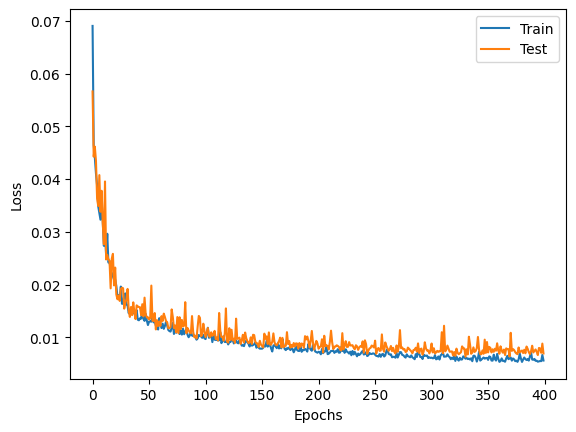

In [10]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(train_loss_all_arr,label='Train')
plt.plot(validation_loss_all_arr,label='Test')
plt.legend()

### 4. 테스트

In [17]:
test_loss = 0
num_batches = len(test_dataloader)
print(num_batches)
bdr_lst = []
label_lst = []
pred_lst = []


for bdr,opr,ux,uy,p in tqdm(test_dataloader):

    # 타입 & device 변환
    bdr = bdr.type(torch.float32).to(device)
    opr = opr.type(torch.int32).to(device)
    ux = ux.type(torch.float32).to(device)
    uy = uy.type(torch.float32).to(device)
    p = p.type(torch.float32).to(device)

    X = [bdr,opr]
    y = torch.concat([ux,uy,p],axis=1)
    
    # 모델 예측
    pred = model(X)
    
    bdr = bdr.to('cpu')
    opr = opr.to('cpu')
    y = y.to('cpu')
    pred = pred.to('cpu')

    bdr_lst.append(bdr)
    label_lst.append(y)
    pred_lst.append(pred)

    # Loss 계산
    loss = loss_fn(pred,y)

    # LOSS 
    test_loss += loss.item() # item()을 통해, 변수에서 값만 가져옴

14


 64%|██████▍   | 9/14 [00:00<00:00, 82.74it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB. GPU 0 has a total capacty of 79.11 GiB of which 21.81 MiB is free. Process 331348 has 75.14 GiB memory in use. Process 340225 has 2.26 GiB memory in use. Process 1155792 has 1.66 GiB memory in use. Of the allocated memory 1007.12 MiB is allocated by PyTorch, and 18.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
batch_num = 3
plt.figure(figsize=[8,3])
plt.imshow(bdr_lst[0][batch_num][0].detach().numpy())

In [ ]:
plot_dic = {0:PreprocessObj.DataConfig.ux_max,
            1:PreprocessObj.DataConfig.uy_max,
            2:PreprocessObj.DataConfig.p_max}
plot_subject = 0
plt.figure(figsize=[8,10])
for idx in [1,3,5]:
    plt.subplot(3,2,idx)
    plt.imshow(label_lst[0][batch_num][plot_subject].detach().numpy()*plot_dic[plot_subject],cmap='jet')
    plt.title('Label')
    plt.colorbar()
    plt.subplot(3,2,idx+1)
    plt.imshow(pred_lst[0][batch_num][plot_subject].detach().numpy()*plot_dic[plot_subject],cmap='jet')
    plt.title('Prediction')
    plt.colorbar()
    plot_subject += 1